## CAPM Simulation_Jegadeesh et al. (2018) 

In [2]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [3]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
from datetime import datetime
import linearmodels

In [4]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [5]:
ols_model = LinearRegression()

In [6]:
## Newey-West Adjustment 
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

In [7]:
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

## Import the simulation parameters from Jegadeesh et al. (2018)

In [8]:
# Import MKT  
mean_MKT = 5.80/100/252
sd_MKT = 15.33/100/np.sqrt(252)
print(mean_MKT, sd_MKT)

0.00023015873015873014 0.009656992285385755


In [9]:
# Import betas
m_all_betas = 0.95
sd_all_betas = 0.42
print(m_all_betas, sd_all_betas)

0.95 0.42


In [10]:
# Import residual sigmas
m_all_sigmas = 58.73/100/252
sd_all_sigmas = 23.81/100/np.sqrt(252)
print(m_all_sigmas, sd_all_sigmas)

0.0023305555555555553 0.014998890170582832


## beta,i and res_sigma,i are fixed through 100 repetitions

In [11]:
# How many stocks in the simulation sample on cross-section
N = 2000

In [12]:
# How many days in the simulation sample on time-series
T = 684*21

In [13]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
print(np.mean(sim_betas_tmp), np.std(sim_betas_tmp))

0.9468959855265248 0.41709706633645216


In [14]:
## ** the betas and sigma(i,resids) are generated at the begining of each simulation and keep them constant
## across 1000 repetitions 
sim_betas = pd.DataFrame(sim_betas_tmp)
# sim_betas = sim_betas.iloc[sim_betas.index.repeat(len(df_Ex_SR)),:]
# sim_betas = sim_betas.reset_index(drop = True)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.353495,0.79056,0.93705,0.085725,1.043581,1.34828,0.969734,1.611401,0.837307,1.160541,...,1.24135,1.438818,0.245666,2.101196,0.363735,1.229948,0.656266,1.313458,1.278244,1.163292


In [15]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.002394344258035642, 0.014901420724523546)

In [16]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.022155,0.007614,0.008453,0.011988,0.000292,0.037079,0.017487,0.000391,0.025804,0.010147,...,0.000241,0.001062,0.005866,0.005982,0.009463,0.010288,0.013973,0.000229,0.012436,0.005353


In [17]:
## sum negative values in sim_sig_res
sim_sig_res.values.flatten()
sum(n < 0 for n in sim_sig_res.values.flatten())

0

In [18]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [32]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= T))
print(mean_MKT, sd_MKT)
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00023015873015873014 0.009656992285385755
0.00022378548953204462 0.009737535749326332


In [33]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
2000-01-05,0.007836
2000-01-06,0.009891
2000-01-07,0.004512
2000-01-08,0.015421
2000-01-09,0.005118
...,...
2039-04-29,0.001689
2039-04-30,-0.019812
2039-05-01,-0.010656
2039-05-02,0.014916


In [34]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [35]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.035602,-0.004390,0.001827,-0.010272,-0.000455,-0.024176,0.015592,-0.000489,-0.007034,-0.004478,...,-0.000063,-0.000900,-0.000099,-0.004185,-0.007546,-0.006509,0.009890,0.000058,0.028347,-0.002455
1,0.009857,0.000290,-0.006462,0.029556,0.000101,0.015208,-0.023437,0.001104,0.011079,0.012952,...,-0.000090,0.000289,0.014984,-0.005711,0.008288,-0.015371,0.016210,-0.000220,-0.000213,-0.000250
2,0.000769,0.000171,0.001475,0.024336,-0.000147,0.020991,-0.008564,-0.000171,0.021054,-0.013711,...,-0.000166,0.000365,-0.002141,-0.002977,-0.012658,-0.001321,0.004280,0.000029,0.010307,0.002427
3,0.000224,-0.004041,-0.007787,0.011891,0.000017,-0.026303,0.016205,-0.000513,-0.023344,-0.007202,...,-0.000103,0.001359,0.003510,0.005141,-0.001302,-0.009213,-0.005485,-0.000079,0.010155,-0.000057
4,-0.009133,0.007846,0.008496,-0.010857,0.000075,-0.043190,-0.018670,0.000552,0.025451,0.005932,...,0.000114,-0.000964,-0.003480,0.002424,-0.000752,0.009456,0.000320,0.000056,0.013747,0.001204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14359,-0.002371,-0.008117,0.006887,0.001209,-0.000101,0.013242,0.018879,0.000551,0.017472,0.008995,...,-0.000268,-0.000631,0.000587,0.002621,0.003032,-0.020677,0.010985,-0.000007,0.000621,0.016759
14360,-0.008429,-0.004256,0.000708,-0.005678,0.000188,-0.031272,0.000185,0.000169,0.016181,0.001706,...,0.000121,0.001833,0.006255,0.005171,0.014146,-0.011939,-0.032240,0.000190,0.007390,-0.001602
14361,-0.011053,0.004025,0.006838,-0.008217,0.000331,-0.042775,-0.015436,-0.000189,-0.002976,0.003386,...,0.000202,-0.000355,0.003513,0.003070,0.010965,0.013255,-0.025679,0.000281,0.003971,-0.007034
14362,-0.045365,0.003202,0.003339,0.011178,0.000534,0.050606,0.024600,-0.000004,-0.013641,-0.001753,...,0.000128,0.001520,0.003046,0.002705,-0.013327,0.013667,-0.007520,-0.000064,-0.003123,-0.000352


In [36]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [51]:
errors = []
errors.append(np.random.normal(loc = 0,scale = sd_MKT, size= len(sim_MKT)))
print(np.mean(errors), np.std(errors))

9.224150571689174e-05 0.009695254449635543


In [52]:
errors = pd.DataFrame(errors).T
errors.index = sim_MKT.index
errors

,0
2000-01-05,0.012293
2000-01-06,0.005778
2000-01-07,0.004676
2000-01-08,-0.006633
2000-01-09,-0.001925
...,...
2039-04-29,0.009972
2039-04-30,0.010896
2039-05-01,0.009706
2039-05-02,0.008214


In [63]:
B_sim_MKT = np.subtract(sim_MKT, errors)
B_sim_MKT

<ipython-input-63-56be6988cfb7>:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  B_sim_MKT = np.subtract(sim_MKT, errors)


,RM-RF
2000-01-05,-0.004457
2000-01-06,0.004113
2000-01-07,-0.000164
2000-01-08,0.022055
2000-01-09,0.007044
...,...
2039-04-29,-0.008284
2039-04-30,-0.030708
2039-05-01,-0.020363
2039-05-02,0.006702


In [64]:
sim_SR = (np.mat(B_sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
# sim_SR.columns = df_betas.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2000-01-05,0.034026,-0.007914,-0.002350,-0.010654,-0.005107,-0.030186,0.011269,-0.007672,-0.010766,-0.009651,...,-0.005597,-0.007314,-0.001194,-0.013551,-0.009167,-0.011991,0.006965,-0.005796,0.022650,-0.007640
2000-01-06,0.011311,0.003542,-0.002609,0.029909,0.004393,0.020753,-0.019449,0.007731,0.014523,0.017724,...,0.005015,0.006206,0.015995,0.002931,0.009784,-0.010313,0.018908,0.005182,0.005044,0.004534
2000-01-07,0.000711,0.000042,0.001322,0.024322,-0.000318,0.020771,-0.008723,-0.000435,0.020918,-0.013901,...,-0.000369,0.000130,-0.002181,-0.003320,-0.012718,-0.001522,0.004173,-0.000186,0.010098,0.002237
2000-01-08,0.008020,0.013394,0.012880,0.013782,0.023032,0.003433,0.037592,0.035026,-0.004877,0.018393,...,0.027275,0.033091,0.008928,0.051482,0.006720,0.017913,0.008988,0.028889,0.038346,0.025599
2000-01-09,-0.006643,0.013415,0.015096,-0.010253,0.007426,-0.033693,-0.011840,0.011903,0.031349,0.014107,...,0.008857,0.009170,-0.001750,0.017225,0.001810,0.018119,0.004942,0.009308,0.022751,0.009398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039-04-29,-0.005300,-0.014665,-0.000875,0.000499,-0.008745,0.002074,0.010847,-0.012797,0.010536,-0.000619,...,-0.010551,-0.012549,-0.001448,-0.014785,0.000019,-0.030865,0.005549,-0.010887,-0.009968,0.007123
2039-04-30,-0.019285,-0.028533,-0.028067,-0.008311,-0.031859,-0.072676,-0.029594,-0.049314,-0.009531,-0.033933,...,-0.037999,-0.042351,-0.001289,-0.059353,0.002977,-0.049709,-0.052393,-0.040144,-0.031862,-0.037325
2039-05-01,-0.018251,-0.012073,-0.012242,-0.009963,-0.020919,-0.070229,-0.035183,-0.033001,-0.020026,-0.020246,...,-0.025075,-0.029653,-0.001489,-0.039716,0.003558,-0.011790,-0.039043,-0.026465,-0.022057,-0.030721
2039-05-02,-0.042996,0.008500,0.009619,0.011752,0.007528,0.059642,0.031099,0.010796,-0.008029,0.006025,...,0.008448,0.011163,0.004693,0.016788,-0.010889,0.021911,-0.003122,0.008739,0.005444,0.007445


In [65]:
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [110]:
B_m_sim_MKT = B_sim_MKT
B_m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
B_m_sim_MKT = B_m_sim_MKT.groupby('month').sum()
B_sim_MKT = B_sim_MKT.drop(['month'], axis = 1)
B_m_sim_MKT = B_m_sim_MKT.iloc[:-1,:]
B_m_sim_MKT

,RM-RF
month,
2000-01,0.066639
2000-02,-0.021672
2000-03,0.051475
2000-04,0.019618
2000-05,0.060652
...,...
2056-07,-0.043057
2056-08,-0.011510
2056-09,-0.022138


In [66]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.053436,0.029576,0.062427,0.056732,0.068283,-0.016614,0.100124,0.108361,0.306139,0.093118,...,0.081679,0.101919,0.034044,0.161789,-0.013195,0.075748,0.004349,0.086285,0.102299,0.087359
2000-02,0.099786,-0.010786,-0.104543,0.038957,-0.024270,0.033427,-0.075793,-0.035317,-0.141051,-0.009876,...,-0.026417,-0.023723,0.033484,-0.048133,-0.064198,0.031094,-0.026576,-0.028245,-0.000851,0.009370
2000-03,-0.092390,-0.016712,0.052289,-0.092380,0.053726,-0.121810,0.009208,0.084391,-0.068983,0.127636,...,0.064516,0.070991,0.020697,0.095518,0.028190,0.033233,0.121669,0.066124,0.015694,0.045138
2000-04,-0.000459,-0.022422,0.011885,-0.037463,0.019201,-0.071763,-0.068010,0.030877,0.123200,-0.041259,...,0.024706,0.016934,-0.044418,0.105196,0.021432,0.003657,0.067184,0.025445,0.101843,0.018428
2000-05,-0.132595,0.046940,-0.012834,0.090745,0.064968,-0.174176,0.043777,0.098248,0.121175,0.069675,...,0.075682,0.087489,0.024885,0.188505,0.009055,0.114662,0.039286,0.079921,0.134947,0.085600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056-08,0.113791,-0.035765,0.000617,-0.049258,-0.012052,-0.158859,-0.148077,-0.018896,-0.056316,-0.066231,...,-0.014967,-0.021673,0.001749,-0.019355,-0.082328,-0.052612,0.048204,-0.014525,0.073311,-0.022103
2056-09,0.171183,-0.014313,0.011005,-0.030035,-0.024186,-0.170789,-0.079721,-0.036719,-0.006564,-0.042060,...,-0.027557,-0.033799,-0.013977,-0.038768,0.036080,0.029227,-0.065152,-0.030020,0.089826,0.016625
2056-10,-0.090716,-0.047710,-0.070982,0.005848,-0.123012,-0.296493,-0.125894,-0.188429,-0.011156,-0.127964,...,-0.146055,-0.177926,-0.027107,-0.265559,-0.048588,-0.101458,0.004661,-0.154415,-0.119544,-0.145421


In [67]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.110632
2000-02,-0.024539
2000-03,0.056440
2000-04,0.050702
2000-05,0.024396
...,...
2056-08,-0.012224
2056-09,0.008173
2056-10,-0.055118


In [ ]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [68]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:               2000   R-squared:                      0.2336
No. Factors:                          1   J-statistic:                    2249.1
No. Observations:                 14364   P-value                         0.0001
Date:                  Tue, Mar 29 2022   Distribution:               chi2(1999)
Time:                          01:25:00                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0001     0.0001     1.1614     0.2455  -9.192e-05      0.0004
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [69]:
print(res_ols.risk_premia.values, res_ols.risk_premia_tstats.values)

[0.00013367] [1.16135582]


In [70]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT))/np.mean(sim_MKT)*100).values))

ex-ante bias(%):[-41.92333233]
ex-post bias(%):[-40.26935298]


In [71]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

## OLS (Time-varying Betas)

In [72]:
# how many years in the rolling window periods
n = 1

In [73]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

671 252


In [74]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 671/671 [09:34<00:00,  1.17it/s]


In [75]:
all_betas[0]

,Intercepts,MKT
0,0.000207,0.106848
1,-0.000979,0.725840
2,-0.000643,0.927727
3,0.000041,0.061272
4,-0.000347,1.062794
...,...,...
1995,-0.000748,1.285949
1996,-0.000713,0.508155
1997,-0.000425,1.334006
1998,-0.000745,1.459367


In [76]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9726312876767356 5601.506454614823


In [77]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

671 12


In [78]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 671/671 [00:01<00:00, 553.41it/s]


In [79]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.005988,-0.094569
1,-0.007183,-0.101624
2,-0.012245,-0.089024
3,-0.001253,0.060582
4,0.007877,0.078403
...,...,...
666,-0.004086,-0.039158
667,-0.002029,-0.009447
668,0.003452,-0.025798
669,-0.000294,-0.128209


In [80]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
0,-0.062910,-0.033517,0.024955,0.006157,-0.060484,-0.095872,0.138719,0.054675,-0.011974,-0.052744,...,0.076637,-0.116205,-0.017321,0.119231,0.113990,-0.107327,0.118613,0.174262,-0.056036,-0.015836
1,0.001197,0.003111,0.049985,0.003938,0.037608,-0.002291,-0.005497,0.007295,-0.054313,0.022282,...,0.029151,-0.009111,0.018284,-0.029957,0.028870,-0.012170,-0.025982,0.002941,0.044561,-0.003897
2,-0.016276,-0.029814,-0.023645,-0.016689,-0.018125,-0.018355,0.022540,0.018949,0.025431,0.016437,...,-0.018910,0.005944,-0.022885,-0.014764,-0.025386,0.014924,0.011015,0.030114,0.040308,0.016830
3,-0.053508,-0.002655,-0.107262,-0.040304,0.024335,-0.058452,0.043792,-0.055844,0.084849,-0.072673,...,-0.004392,-0.046659,-0.025335,-0.026566,-0.002743,-0.010954,-0.044689,-0.025663,0.035725,0.082154
4,0.001506,0.000305,0.000476,0.004274,0.002343,-0.000859,-0.004001,-0.004890,-0.002501,-0.001005,...,-0.002389,-0.001648,0.002473,-0.000265,0.002288,-0.003548,-0.000619,-0.002112,-0.000279,0.005446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.040030,-0.025442,0.024426,-0.077167,-0.042428,-0.071128,-0.036204,0.015263,0.024929,0.007666,...,0.060773,0.047178,0.015881,0.015184,-0.019025,-0.005608,-0.039625,0.055821,0.044403,0.013771
1996,-0.028460,-0.023751,0.023218,-0.022571,-0.039367,0.023625,0.029419,0.036791,0.102508,-0.044974,...,0.030779,0.110079,0.069909,0.002461,-0.001807,-0.091877,0.056777,-0.049981,0.084610,-0.073870
1997,-0.002380,-0.002460,-0.002860,0.000954,0.003359,-0.002156,-0.008314,-0.001658,-0.002499,0.001152,...,-0.002315,-0.002370,0.004200,-0.001005,0.002656,-0.003906,-0.000631,-0.001237,0.000391,0.008636
1998,-0.017301,0.077793,-0.050290,0.124625,0.002476,0.003806,0.069124,-0.067894,-0.058881,0.006549,...,-0.097537,-0.016729,-0.081202,-0.012095,0.052769,0.133518,0.086459,0.116839,0.027060,0.022020


In [81]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([1.59257468, 1.04592243]), pvalue=array([0.11172728, 0.29597403]))

In [82]:
## New-West Adjustment for CAPM lambda
all_lambdas_OLS[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.97855098, 0.65125078])

In [83]:
print(mean_MKT*21, np.mean(m_sim_MKT.values), np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.004833333333333333 0.004699495280172936 0.002569491233448646


In [84]:
# Test whether the betas in FM-2 is endougenous

In [85]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

-2.3934853622992216e-18 x is Exogenous


In [112]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(mean_MKT*21))/(np.mean(mean_MKT*21))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(B_m_sim_MKT.values))/np.mean(B_m_sim_MKT.values)*100))

ex-ante bias(%): -46.838112411407316
ex-post bias(%): -5.224544340914479


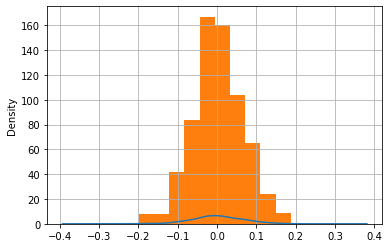

In [87]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [88]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

252 671


In [89]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 671/671 [25:17<00:00,  2.26s/it]


In [90]:
all_betas_ev[0]

,0
0,0.236514
1,0.809301
2,1.027722
3,0.123592
4,1.183450
...,...
1995,1.577731
1996,0.677842
1997,1.485971
1998,1.764244


In [91]:
all_betas_iv[0]

,0
0,0.002220
1,0.645072
2,0.832861
3,0.002306
4,0.950985
...,...
1995,1.010610
1996,0.349642
1997,1.193471
1998,1.174847


In [92]:
## Calculating the estimated lambdas

In [93]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

671 12


In [94]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 671/671 [00:03<00:00, 167.92it/s]


In [95]:
# Use the IV estimator equation to calculate lambdas

In [96]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
0,-0.058155,-0.019018,0.036160,-0.000602,-0.066436,-0.095667,0.133223,0.053528,-0.011935,-0.039615,...,0.080868,-0.106109,-0.019979,0.121340,0.112871,-0.107104,0.118992,0.176953,-0.037611,-0.016310
1,-0.000695,0.003733,0.053118,0.000815,0.032020,-0.000448,0.000821,0.006292,-0.054957,0.021760,...,0.030680,-0.006688,0.015917,-0.028868,0.028050,-0.010855,-0.025538,0.004545,0.046090,-0.003653
2,-0.017473,-0.030480,-0.024493,-0.015574,-0.014995,-0.019269,0.016998,0.019704,0.025905,0.019937,...,-0.024513,-0.004184,-0.019197,-0.016556,-0.023693,0.013259,0.010638,0.029329,0.038949,0.016568
3,-0.054672,-0.009185,-0.121596,-0.032744,0.029904,-0.062942,0.026316,-0.055650,0.084460,-0.062060,...,-0.005422,-0.048845,-0.028354,-0.027265,-0.002561,-0.016225,-0.045720,-0.028594,0.009241,0.087391
4,0.001643,0.000437,0.000784,0.003754,0.002211,-0.000609,-0.003393,-0.004737,-0.002366,-0.001142,...,-0.001986,-0.000797,0.002345,-0.000092,0.002175,-0.003017,-0.000536,-0.001968,0.000907,0.005316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.054782,-0.009338,0.035592,-0.086630,-0.053938,-0.066889,-0.020026,0.014363,0.024438,-0.000255,...,0.063111,0.052538,0.015959,0.014452,-0.018193,-0.005785,-0.039577,0.055398,0.044817,0.014078
1996,-0.021675,-0.016024,0.023838,-0.020787,-0.034972,0.023322,0.026382,0.036826,0.102172,-0.046397,...,0.036106,0.120051,0.064909,0.005042,-0.003864,-0.089419,0.056984,-0.050062,0.073678,-0.072346
1997,-0.000485,-0.001132,-0.001237,-0.000696,0.003181,-0.001319,-0.006311,-0.001081,-0.002011,0.000749,...,-0.000742,0.000498,0.003998,-0.000492,0.002254,-0.001805,-0.000280,-0.000697,0.004282,0.008232
1998,-0.002053,0.086506,-0.045353,0.120338,-0.003045,0.005200,0.071592,-0.067125,-0.058590,0.011008,...,-0.099934,-0.020106,-0.079175,-0.012378,0.052868,0.133753,0.086760,0.117076,0.029840,0.021960


In [97]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

5.779718585664157e-18 IV is Exogenous


In [98]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.001851832283229404 EV is Endogenous


In [99]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [100]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.8947310504243351 IV is Strong


In [101]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [102]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.9464084647716671 2130.467135925827


In [103]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.000578,-0.090591
1,-0.002510,-0.092016
2,-0.006966,-0.082410
3,-0.005845,0.057787
4,0.006970,0.071356
...,...,...
666,0.000945,-0.046734
667,-0.001179,-0.010782
668,0.004705,-0.028078
669,0.008588,-0.147903


In [104]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([1.0353012 , 1.17375172]), pvalue=array([0.30090179, 0.24091155]))

In [105]:
all_lambdas_IV[0].describe()

,0,1
count,671.000000,671.000000
mean,0.000176,0.003064
std,0.004413,0.067631
min,-0.012763,-0.231995
25%,-0.002656,-0.036668
50%,0.000015,0.000191
75%,0.003162,0.044993
max,0.017831,0.207989


In [106]:
print(np.mean(mean_MKT*21), np.mean(all_lambdas_IV[0].iloc[:,1]))

0.004833333333333333 0.0030644949246540383


In [111]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - mean_MKT*21)/(mean_MKT*21)*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(B_m_sim_MKT.values))/np.mean(B_m_sim_MKT.values)*100))   

ex-ante bias(%): -36.59665673129575
ex-post bias(%): 13.033622792021937
